In [ ]:
n_samples = 50000
n_plot_samples = 100
n_features = 2
mu_c = np.array([1, 1])
mu_e = np.array([1, 1])
Sigma_c = np.array([[1, 0.0], [0.0, 1]])
Sigma_e = np.array([[1, 0.0], [0.0, 1]])

p_y1 = 0.5
p_noise = 0.25

n_Ms = 50

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import random

random.seed(1234)
np.random.seed(1234)

In [ ]:
def generate_distribution(M=np.eye(n_features)):
    Y_true = np.random.choice([-1, 1], p=[1-p_y1, p_y1], size=n_samples)
    noise = np.random.choice([-1, 1], p=[p_noise, 1-p_noise], size=n_samples)
    Y = Y_true * noise

    Z_c = Y_true.reshape(-1,1)*np.random.multivariate_normal(mu_c, Sigma_c, n_samples)
    Z_e = Y.reshape(-1,1)*np.random.multivariate_normal(M@mu_e, M@Sigma_e@M.T, n_samples)
    X = np.hstack((Z_c, Z_e))

    return {'X': X, 'Y': Y, 'Zc': Z_c, 'Ze': Z_e}


In [ ]:
def train_and_test_model(X, Y, test_list):
    clf = LogisticRegression(random_state=0).fit(X, Y)
    res = [accuracy_score(Y, clf.predict(X)) for X, Y in test_list]
    return clf, res

In [ ]:
def generate_pd_nd_pair(n, bound=10):
    """
    Generate a pair of positive definite (PD) and negative definite (ND) matrices with bounded norms.

    Parameters:
    - n: int
        The size of the matrices (n x n).
    - bound: float
        The maximum absolute value for the norm of the matrices.

    Returns:
    - list of numpy.ndarray
        A list containing the positive definite and negative definite matrices.
    """
    # Generate a random symmetric matrix
    A = np.random.randn(n, n)
    symmetric_matrix = (A + A.T) / 2  # Make it symmetric

    # Positive definite matrix
    eig_values = np.abs(np.linalg.eigvals(symmetric_matrix)) + 0.1  # Ensure positive eigenvalues
    pd_matrix = symmetric_matrix @ np.diag(eig_values) @ symmetric_matrix.T

    # Normalize the PD matrix to have a norm of 1
    norm_pd = np.linalg.norm(pd_matrix, ord='fro')  # Frobenius norm
    pd_matrix = (pd_matrix / norm_pd) * bound  # Scale to the desired bound

    # Negative definite matrix
    nd_matrix = -pd_matrix  # Negate to make eigenvalues negative

    return [pd_matrix, nd_matrix]

def generate_Ms(n, d):
    Ms = []
    for i in range(d // 2):
        M = generate_pd_nd_pair(n)
        Ms += M
    return Ms

In [ ]:
def get_inners(M, clf):
    """
    Compute w^T (M * mu_e) for a given matrix M and a trained classifier clf.

    Parameters:
    - M: numpy.ndarray, shape (n_samples, n_features)
        The input matrix where rows are samples and columns are features.
    - clf: Trained sklearn classifier
        A trained classifier with coef_ and intercept_ attributes.

    Returns:
    - numpy.ndarray, shape (n_samples,)
        The inner product w^T (M * mu_e) for each sample in M.
    """
    global mu_e, Sigma_e  # Access the global variables

    # Validate dimensions of mu_e and Sigma_e
    if M.shape[1] != mu_e.shape[0]:
        raise ValueError("mu_e size must match the number of features in M.")
    if Sigma_e.shape[0] != M.shape[1] or Sigma_e.shape[1] != M.shape[1]:
        raise ValueError("Sigma_e dimensions must match (n_features, n_features).")

    # Element-wise multiply M with mu_e
    M_mu_e = M @ mu_e  # Shape: (n_samples, n_features)

    # Compute w^T (M * mu_e)
    coef = clf.coef_[:, n_features:].flatten()  # Shape (n_features,)
    intercept = clf.intercept_[0]  # Shape ()
    inner_product = coef.T@M_mu_e  # + intercept  # Shape: (n_samples,)

    # Compute sqrt(2 * w^T M Sigma_e M^T w) without intercept
    variance_sqrt = np.sqrt(2 * coef.T@M@Sigma_e@M.T@coef)  # Shape: (n_samples,)

    return inner_product, variance_sqrt

In [ ]:
Ms = [np.eye(n_features)] + generate_Ms(n_features, n_Ms)

len(Ms)

source_distribution = generate_distribution()
target_distributions = [generate_distribution(M) for M in Ms]

In [ ]:
test_data = [(d['X'], d['Y']) for d in target_distributions]
dg_test_data = [(d['Zc'], d['Y']) for d in target_distributions]
clf, res = train_and_test_model(source_distribution['X'], source_distribution['Y'], test_data)
_, dg_res = train_and_test_model(source_distribution['Zc'], source_distribution['Y'], dg_test_data)

In [ ]:
x = [get_inners(M, clf) for M in Ms]

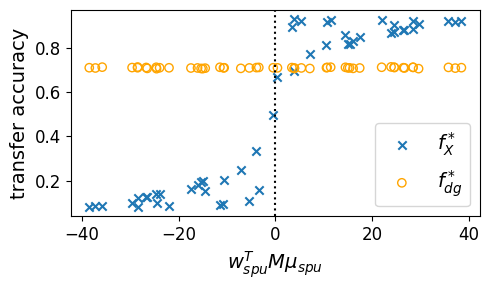

In [ ]:
plt.figure(figsize=(5, 3))
# Condition
cond = [np.abs(i[0]) >= i[1] for i in x]  # Example condition based on x

# Separate the points based on the condition for `res`
plt.scatter([i[0] for i in x], res, marker='x', label=r'$f_{X}^*$',)

# Single scatter plot for `dg_res`
plt.scatter([i[0] for i in x], dg_res, marker='o', facecolors='none', edgecolors='orange', label=r'$f_{dg}^*$')

plt.axvline(0, linestyle=':', color='black')
plt.xlabel(r'$w_{spu}^TM\mu_{spu}$', fontsize=14)
plt.ylabel('transfer accuracy', fontsize=14)
plt.legend(fontsize=14)
rcParams['xtick.labelsize'] = 12  # Set x-tick font size to 12
rcParams['ytick.labelsize'] = 12  # Set y-tick font size to 12
plt.tight_layout()


plt.savefig('guass_sim.pdf', format='pdf', dpi=300)
